# Pandera Workshop: Making Data Processing Pipelines more Readable and Robust

*Global DevSlam x Pycon MEA 2022*

# Outline 📝

- 🤷‍♂️ Why Should I Validate Data?
- 🤔 What's Data Testing, and How Can I Put it Into Practice?
- ✅ Pandera Quickstart: create statistical types for your DataFrames
- ⌨️ Statistical types: A typing paradigm for DS/ML
- 📊 Example 1: Validate your Data analysis
- 🤖 Example 2: Validate your Machine Learning Pipeline
- ⭐️ Conclusion: How can I start using Pandera in my work?

### Setup

In [5]:
%%capture
!pip install 'pandera[all]'

In [1]:
import warnings
from hypothesis.errors import HypothesisWarning

from IPython.display import display, Markdown

warnings.filterwarnings("ignore", category=HypothesisWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Where's the Code?

📓 **Notebook**: https://github.com/pandera-dev/pandera-presentations/blob/master/notebooks/20221012_pycon_mea_workshop.ipynb

# 🤷‍♂️ Why Should I Validate Data?

- 🐞 It can be difficult to reason about and debug data processing pipelines.
- ⚠️ It's critical to ensuring data quality in many contexts especially when the end product informs business decisions, supports scientific findings, or generates predictions in a production setting.
- 📊 Everyone has a personal relationship with their dataframes.

# 🤔 What's Data Testing

> **Data validation:** The act of falsifying data against explicit assumptions for some downstream purpose, like
> analysis, modeling, and visualization.

> **Data Testing:** Validating not only real data, but also the functions that produce them.

# ✅ Pandera

#### A data testing and statistical typing library for DS/ML-oriented data containers

- Check the types and properties of dataframes
- Easily integrate with existing data pipelines via function decorators
- Synthesize data from schema objects for property-based testing

### Pandera Comes in Two Flavors

#### Object-based API

Defining a schema looks and feels like defining a pandas dataframe

In [2]:
import pandera as pa

schema = pa.DataFrameSchema(
    columns={
        "item": pa.Column(str, pa.Check.isin(["apple", "orange"])),
        "price": pa.Column(float, pa.Check.ge(0)),
    },
    coerce=True,
)

#### Class-based API

Define complex types with modern Python, inspired by [pydantic](https://pydantic-docs.helpmanual.io/) and `dataclasses`

In [3]:
from pandera.typing import DataFrame, Series

class Schema(pa.SchemaModel):
    item: Series[str] = pa.Field(isin=["apple", "orange"])
    price: Series[float] = pa.Field(gt=0)

    class Config:
        coerce = True

#### Pandera Raises Informative Errors

With valid data, pandera simply passes the data through:

In [4]:
import pandas as pd

valid_data = pd.DataFrame.from_records([
    {"item": "apple", "price": 0.5},
    {"item": "orange", "price": 0.75}
])

Schema.validate(valid_data)

,item,price
0,apple,0.50
1,orange,0.75


But with invalid data, it'll raise an error, and you'll
know exactly what went wrong with your data.

In [9]:
invalid_data = pd.DataFrame.from_records([
    {"item": "applee", "price": 0.5},
    {"item": "orange", "price": -1000}
])

try:
    Schema.validate(invalid_data, lazy=True)
except (pa.errors.SchemaError, pa.errors.SchemaErrors) as exc:
    display(exc.failure_cases)

,schema_context,column,check,check_number,failure_case,index
0,Column,item,"isin({'apple', 'orange'})",0,applee,0
1,Column,price,greater_than(0),0,-1000.0,1


> 💪 Exercise: Try removing `lazy=True` and see what happens. How is the outcome different?

### Schema Components

### Object-based API

In the Pandera schemas consist of composable components that themselves can be used in isolation

In [11]:
column = pa.Column(str, pa.Check.isin(["apple", "orange"]), name="item")
column.validate(valid_data)

,item,price
0,apple,0.50
1,orange,0.75


#### Class-based API

The class-based API doesn't quite offer this same reusability, but you can still define `Field`s in isolation and reuse them across `SchemaModel` classes.

In [7]:
field = pa.Field(isin=["apple", "orange"])
field

<pandera.model_components.FieldInfo("None") object at 0x1a0b36bc0>

In [8]:
field.to_column(str, name="item").validate(valid_data)

,item,price
0,apple,0.50
1,orange,0.75


> 💪 Exercise: Change the `name="item"` argument to some other name and re-run the above code cells. What happens?

### Checks

`Check` objects are the validation workhorse of pandera. The `Check` class ships with some built-in checks for common use cases, but they are designed to make customizability extremely easy.

As with schema components, we can define and use these by themselves.

In [11]:
gt_check = pa.Check.gt(0)
result = gt_check(pd.Series([1, 2, 3, -1]))
print(f"check_passed:\n{result.check_passed}")
print(f"\ncheck_output:\n{result.check_output}")
print(f"\nfailure_cases:\n{result.failure_cases}")

check_passed:
False

check_output:
0     True
1     True
2     True
3    False
dtype: bool

failure_cases:
3   -1
dtype: int64


#### Custom Checks

Checks have a particular contract, for example, here's a custom check that's equivalent to the built-in `Check.gt(0)` that we defined above:

In [12]:
gt_check = pa.Check(lambda x: x > 0, name="gt_zero")
gt_check(pd.Series([1, 2, 3, -1]))

CheckResult(check_output=0     True
1     True
2     True
3    False
dtype: bool, check_passed=False, checked_object=0    1
1    2
2    3
3   -1
dtype: int64, failure_cases=3   -1
dtype: int64)

Alternatively, we can use functions if you prefer:

In [13]:
def gt_zero(x):
    return x > 0

gt_check = pa.Check(gt_zero)
gt_check(pd.Series([1, 2, 3, -1]))

CheckResult(check_output=0     True
1     True
2     True
3    False
dtype: bool, check_passed=False, checked_object=0    1
1    2
2    3
3   -1
dtype: int64, failure_cases=3   -1
dtype: int64)

> 💪 Exercise: Create a new cell below and define a custom check that makes sure that the mean value of an input `Series` is between 0 and 100. Then create some data that (a) passes the check, then (b) fails the check.

#### Dataframe-level Checks

The signature of the function is flexible in that you can pass into the `Check` object also supports dataframe-level checks. In fact, the pandas API makes it such that the custom checks we defined can be used to validate an entire dataframe:

In [14]:
gt_check(pd.DataFrame([[1, 2, 3]]))

CheckResult(check_output=0  0    True
1  0    True
2  0    True
dtype: bool, check_passed=True, checked_object=   0  1  2
0  1  2  3, failure_cases=Empty DataFrame
Columns: [column, index, failure_case]
Index: [])

You can use these in your schemas like so:

In [15]:
df_schema = pa.DataFrameSchema(checks=gt_check)
df_schema(pd.DataFrame([[1, 2, 3]]))

,0,1,2
0,1,2,3


Dataframe-level checks enable you to apply validation rules in a conditional manner.

Suppose you want to check that column `A` is positive but only if column `B` has a specific value:

In [16]:
def conditional_check(df: pd.DataFrame) -> Series[bool]:
    check_output = pd.Series(True, index=df.index)
    return check_output.mask(df["B"] == "x", df["A"] > 0)


df_schema = pa.DataFrameSchema(checks=pa.Check(conditional_check))
df_schema.validate(pd.DataFrame({"A": [1, 2, -3], "B": ["x", "x", "y"]}))

,A,B
0,1,x
1,2,x
2,-3,y


> 💪 Exercise: Create a new cell below and define a custom dataframe check that makes sure that some column `"A"` is negative if the corresponding value of column `"B"` is not `"x"`

#### Class-based API

Custom checks in the class-based API are defined via methods:

In [17]:
class SchemaWithCustomChecks(pa.SchemaModel):
    @pa.check
    def gt_zero(cls, x: pd.Series) -> Series[bool]:
        return x > 0

SchemaWithCustomChecks.validate(pd.DataFrame([[1, 2, 3]]))

,0,1,2
0,1,2,3


And similarly, we can define dataframe-level checks like so:

In [18]:
class SchemaWithCustomDFChecks(pa.SchemaModel):
    @pa.dataframe_check
    def conditional_check(cls, df: pd.DataFrame) -> Series[bool]:
        check_output = pd.Series(True, index=df.index)
        return check_output.mask(df["B"] == "x", df["A"] > 0)

SchemaWithCustomChecks.validate(pd.DataFrame({"A": [1, 2, -3], "B": ["x", "x", "y"]}))

,A,B
0,1,x
1,2,x
2,-3,y


### Pandera Supports Schema Transformations/Inheritence

#### Object-based API

Dynamically transform schema objects on the fly

In [19]:
schema = pa.DataFrameSchema(
    columns={
        "item": pa.Column(str, pa.Check.isin(["apple", "orange"])),
        "price": pa.Column(float, pa.Check.ge(0)),
    },
    coerce=True,
)

transformed_schema = schema.add_columns({"expiry": pa.Column(pd.Timestamp)})
print(transformed_schema)

<Schema DataFrameSchema(
    columns={
        'item': <Schema Column(name=item, type=DataType(str))>
        'price': <Schema Column(name=price, type=DataType(float64))>
        'expiry': <Schema Column(name=expiry, type=DataType(datetime64[ns]))>
    },
    checks=[],
    coerce=True,
    dtype=None,
    index=None,
    strict=False
    name=None,
    ordered=False,
    unique_column_names=False
)>


> 💪 Exercise: Looking at the [DataFrameSchema API documentation](https://pandera.readthedocs.io/en/stable/reference/generated/pandera.schemas.DataFrameSchema.html#pandera.schemas.DataFrameSchema), modify the `transformed_schema` above by removing the `"price"` column.

#### Class-based API

Inherit from `pandera.SchemaModel` to Define Type Hierarchies

In [20]:
from pandera.typing import DataFrame, Series

class Schema(pa.SchemaModel):
    item: Series[str] = pa.Field(isin=["apple", "orange"])
    price: Series[float] = pa.Field(gt=0)

    class Config:
        coerce = True

class TransformedSchema(Schema):
    expiry: Series[pd.Timestamp]


print(TransformedSchema.to_schema())

<Schema DataFrameSchema(
    columns={
        'item': <Schema Column(name=item, type=DataType(str))>
        'price': <Schema Column(name=price, type=DataType(float64))>
        'expiry': <Schema Column(name=expiry, type=DataType(datetime64[ns]))>
    },
    checks=[],
    coerce=True,
    dtype=None,
    index=None,
    strict=False
    name=TransformedSchema,
    ordered=False,
    unique_column_names=False
)>


> 💪 Exercise: Inherit from `TransformedSchema` to create a new schema and add a new column `category` of type `str`, where values in that column must be in the set `{"fruit", "vegetables", "meat"}`.

### Integrate Seamlessly with your Pipeline

Use decorators to add IO checkpoints to the critical functions in your pipeline

#### Object-based API

Use the `pandera.check_io` decorator to validate input and output dataframes at runtime using `DataFrameSchema` objects.

In [21]:
from typing import List
from datetime import datetime

@pa.check_io(data=schema, out=transformed_schema)
def transform_data(data, expiry: List[datetime]):
    return data.assign(expiry=expiry)

transform_data(valid_data, [datetime.now()] * valid_data.shape[0])

,item,price,expiry
0,apple,0.50,2022-10-12 08:32:41.182470
1,orange,0.75,2022-10-12 08:32:41.182470


#### Class-based API

Use the `pandera.check_types` decorator to validate input/output dataframes at runtime using `SchemaModel` classes.

In [22]:
from typing import List
from datetime import datetime


@pa.check_types
def transform_data(data: DataFrame[Schema], expiry: List[datetime]) -> DataFrame[TransformedSchema]:
    return data.assign(expiry=expiry)


transform_data(valid_data, [datetime.now()] * valid_data.shape[0])

,item,price,expiry
0,apple,0.50,2022-10-12 08:32:41.946073
1,orange,0.75,2022-10-12 08:32:41.946073


> 💪 Exercise: Try introducing a bug in the `transform_data` function above that causes a `SchemaError`. How many different kinds of errors can you introduce?

### Generative Schemas

Schemas that synthesize valid data under its constraints

In [23]:
Schema.example(size=5)

,item,price
0,apple,9.999900e-01
1,apple,2.000010e+00
2,apple,1.900000e+00
3,orange,3.402823e+38
4,orange,1.000000e+00


**Data Testing:** Test the functions that produce clean data

In [24]:
from hypothesis import given


@given(Schema.strategy(size=5))
def test_fn(data):
    transform_data(data, [datetime.now()] * data.shape[0])


def run_test_suite():
    test_fn()
    print("tests passed ✅")


run_test_suite()

tests passed ✅


> 💪 Exercise: Introduce a `print` function call to the `test_fn` above to see what data exactly is being generated by `hypothesis`.

## Scaling Pandera

Pandera supports `dask`, `modin`, and `pyspark.pandas` dataframes to scale
data validation to big data.

In [25]:
display(invalid_data)

,item,price
0,applee,0.5
1,orange,-1000.0


### Apply a single schema to a suite of dataframe-like objects

#### `dask`

In [26]:
import dask.dataframe as dd

dask_dataframe = dd.from_pandas(invalid_data, npartitions=1)

try:
    Schema(dask_dataframe, lazy=True).compute()
except pa.errors.SchemaErrors as exc:
    display(exc.failure_cases.sort_index())

,schema_context,column,check,check_number,failure_case,index
0,Column,item,"isin({'apple', 'orange'})",0,applee,0
1,Column,price,greater_than(0),0,-1000.0,1


### Apply a single schema to a suite of dataframe-like objects

#### `modin`

In [27]:
import modin.pandas as mpd

modin_dataframe = mpd.DataFrame(invalid_data)

try:
    Schema(modin_dataframe, lazy=True)
except pa.errors.SchemaErrors as exc:
    display(exc.failure_cases.sort_index())

(pid=94535) FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
(pid=94535) FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
(pid=94536) FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


,schema_context,column,check,check_number,failure_case,index
0,Column,item,"isin({'apple', 'orange'})",0,applee,0
1,Column,price,greater_than(0),0,-1000.0,1


### Apply a single schema to a suite of dataframe-like objects

#### `pyspark.pandas`

In [29]:
import pyspark.pandas as ps

pyspark_pd_dataframe = ps.DataFrame(invalid_data)

try:
    Schema(pyspark_pd_dataframe, lazy=True)
except pa.errors.SchemaErrors as exc:
    display(exc.failure_cases.sort_index())

/Users/nielsbantilan/miniconda3/envs/pandera-presentations/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/Users/nielsbantilan/miniconda3/envs/pandera-presentations/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/Users/nielsbantilan/miniconda3/envs/pandera-presentations/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/Users/nielsbantilan/miniconda3/envs/pandera-presentations/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items inste

,schema_context,column,check,check_number,failure_case,index
0,Column,item,"isin({'apple', 'orange'})",0,applee,0
1,Column,price,greater_than(0),0,-1000.0,1


### Schema Inference

You can bootstrap a schema if you want to quickly create a schema that you can refine further:

In [48]:
schema = pa.infer_schema(valid_data)

In [52]:
print(schema.to_script())

from pandera import DataFrameSchema, Column, Check, Index, MultiIndex

schema = DataFrameSchema(
    columns={
        "item": Column(
            dtype=pandera.engines.numpy_engine.Object,
            checks=None,
            nullable=False,
            unique=False,
            coerce=False,
            required=True,
            regex=False,
            description=None,
            title=None,
        ),
        "price": Column(
            dtype=pandera.engines.numpy_engine.Float64,
            checks=[
                Check.greater_than_or_equal_to(min_value=0.5),
                Check.less_than_or_equal_to(max_value=0.75),
            ],
            nullable=False,
            unique=False,
            coerce=False,
            required=True,
            regex=False,
            description=None,
            title=None,
        ),
    },
    index=Index(
        dtype=pandera.engines.numpy_engine.Int64,
        checks=[
            Check.greater_than_or_equal_to(min_value=0.0),


## ⌨️ Statistical Typing

#### Type systems help programmers reason about and write more robust code

In [30]:
from typing import Union

Number = Union[int, float]

def add_and_double(x: Number, y: Number) -> Number:
    ...

#### Can you predict the outcome of these function calls?

In [31]:
add_and_double(5, 2)
add_and_double(5, "hello")
add_and_double(11.5, -1.5)

#### Similarly...

In [32]:
import pandera as pa
from pandera.typing import DataFrame, Series

class Inputs(pa.SchemaModel):
    x: Series[int]
    y: Series[int]

    class Config:
        coerce = True


class Outputs(Inputs):
    z: Series[int]
        
    @pa.dataframe_check
    def custom_check(cls, df: DataFrame) -> Series:
        return df["z"] == (df["x"] + df["y"]) * 2
    
    
@pa.check_types
def add_and_double(raw_data: DataFrame[Inputs]) -> DataFrame[Outputs]:
    ...

### 🤔 What's Statistical Typing?

> **Statistical typing** extends primitive data types with additional semantics
> about the _properties held by a collection of data points_.

#### Consider a single data point

In [ ]:
data_point = {"square_footage": 700, "nbedrooms": 1, "price": 500_000}

- Primitive datatypes
- Value range
- Allowable values
- Regex string match
- Nullability

#### Now consider a collection data point

In [ ]:
data_points = [
    {"square_footage": 700, "nbedrooms": 1, "price": 500_000},
    {"square_footage": 1000, "nbedrooms": 2, "price": 750_000},
    {"square_footage": 3000, "nbedrooms": 4, "price": 1_000_000},
    ...
]

- Apply atomic checks at scale
- Uniqueness
- Monotonicity
- Mean, median, standard deviation
- Fractional checks, e.g. 90% of data points are not null

### Pandera is a Statistical Type System Geared Towards Data Science

Statistical types are defined with multiple layers 🧅

> **primitive data types**: `int`, `float`, `bool`, `str`, etc.

> **deterministic properties**: domain of possible values, e.g. `x >= 0`

> **probabilistic properties**: distributions that apply to the variable and their sufficient statistics, e.g. `mean`,
  `standard deviation`

# 📊 Example 1: Validate your Data analysis

## Dataset: California Housing

A dataset containing ~20,000 samples where each row is a California district and
each column is an aggregate statistic about that district.

In [33]:
from sklearn.datasets import fetch_california_housing

housing_data = fetch_california_housing(as_frame=True).frame
housing_data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


#### With a cursory glance at the data...

In [34]:
housing_data.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


#### We can start defining a basic schema

In [35]:
class HousingData(pa.SchemaModel):

    # features
    MedInc: Series[float] = pa.Field(in_range={"min_value": 0, "max_value": 100})
    HouseAge: Series[float] = pa.Field(in_range={"min_value": 0, "max_value": 100})
    AveRooms: Series[float] = pa.Field(in_range={"min_value": 0, "max_value": 1_000})
    AveBedrms: Series[float] = pa.Field(in_range={"min_value": 0, "max_value": 100})
    Population: Series[float] = pa.Field(in_range={"min_value": 0, "max_value": 100_000})
    AveOccup: Series[float] = pa.Field(in_range={"min_value": 0, "max_value": 10_000})
    Latitude: Series[float] = pa.Field(in_range={"min_value": -90, "max_value": 90})
    Longitude: Series[float] = pa.Field(in_range={"min_value": -180, "max_value": 180})

    # target variable! 🎯
    MedHouseVal: Series[float] = pa.Field(in_range={"min_value": 0, "max_value": 100})

    class Config:
        coerce = True


@pa.check_types
def read_data() -> DataFrame[HousingData]:
    return fetch_california_housing(as_frame=True).frame


housing_data = read_data()
print("validation passed ✅")

validation passed ✅


### Analysis Pipeline

Hypothesis: Median income is positively correlated with Median House Value

Pearson correlation coefficient = 0.688075

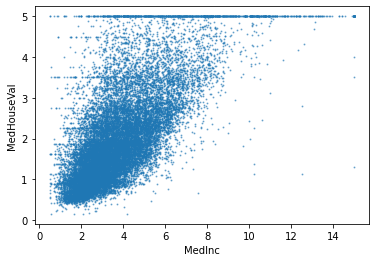

In [36]:
def analyze_data(housing_data, var1, var2):
    correlation_coef = housing_data[[var1, var2]].corr().at[var1, var2]
    display(Markdown(f"Pearson correlation coefficient = {correlation_coef:0.06f}"))
    housing_data.plot.scatter(var1, var2, s=1, alpha=0.5)

analyze_data(housing_data, "MedInc", "MedHouseVal")

#### Bake in statistical hypothesis testing into your pipeline

Easily create re-usable custom checks

In [37]:
from scipy.stats import pearsonr
import pandera.extensions as extensions

@extensions.register_check_method(
    statistics=["var1", "var2", "alpha"],
    supported_types=[pd.DataFrame]
)
def is_positively_correlated(
    df: pd.DataFrame,
    *,
    var1: str,
    var2: str,
    alpha: float = 0.01,
):
    """Perform Pearson correlation hypothesis test."""

    r, pvalue = pearsonr(df[var1], df[var2])
    passed = r > 0 and pvalue <= alpha

    pretty_pvalue = np.format_float_scientific(pvalue)
    if passed:
        print(f"✅ {var1} is positively correlated with {var2} with r = {r:0.04f}; pvalue = {pretty_pvalue}")
    else:
        print(f"❌ {var1} not correlated with {var2} with with r = {r:0.04f}; pvalue = {pretty_pvalue}")

    return passed

#### Dynamically create schemas as statistical hypothesis validators

✅ MedInc is positively correlated with MedHouseVal with r = 0.6881; pvalue = 0.e+00


Pearson correlation coefficient = 0.688075

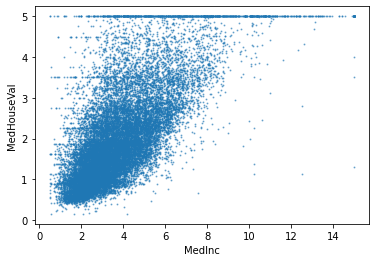

In [38]:
def analyze_data(housing_data, var1: str, var2: str):

    class HousingDataHypothesis(HousingData):
        class Config:
            coerce = True
            is_positively_correlated = {
                "var1": var1,
                "var2": var2,
                "alpha": 0.01,
            }

    housing_data = HousingDataHypothesis.validate(housing_data)
    correlation_coef = housing_data[[var1, var2]].corr().at[var1, var2]
    display(Markdown(f"Pearson correlation coefficient = {correlation_coef:0.06f}"))
    housing_data.plot.scatter(var1, var2, s=1, alpha=0.5)


analyze_data(housing_data, "MedInc", "MedHouseVal")

> 💪 Exercise: Create some new cells below to explore the housing data set some more and formulate a hypothesis about it. Then, create a custom check extension using `@extensions.register_check_method` to test that hypothesis. Finally, define a schema that uses that newly created check in a `SchemaModel` subclass to test the hypothesis.

#### The Analysis Pipeline

Every time this runs, pandera makes sure all the assumptions encoded in the schemas
hold true.

✅ MedInc is positively correlated with MedHouseVal with r = 0.6881; pvalue = 0.e+00


Pearson correlation coefficient = 0.688075

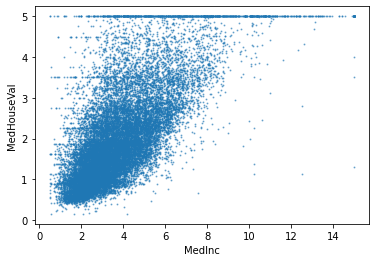

In [39]:
def run_analysis_pipeline(var1: str, var2: str):
    data = read_data()
    analyze_data(data, var1, var2)


run_analysis_pipeline("MedInc", "MedHouseVal")

# 🤖 Example 2: Validate your Machine Learning Pipeline

### Prediction Task:

From all the features, predict the median house value target `MedHouseVal`.

In [40]:
from typing import Tuple

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


# ⚠️ This is the most critical part to check
@pa.check_types
def split_data(
    data: DataFrame[HousingData],
    test_size: float = 0.2,
) -> Tuple[DataFrame[HousingData], DataFrame[HousingData]]:
    return train_test_split(data, test_size=test_size)


# 👉 Notice that I don't use @pa.check_types here
def parse_data(data: DataFrame[HousingData], target: str) -> Tuple[DataFrame[HousingData], pd.Series]:
    features = [column for column in data if column != target]
    return data[features], data[target]


# 🔽 At this point onward the type annotations are for type linters like mypy
def train(features: pd.DataFrame, target: pd.Series) -> LinearRegression:
    model = LinearRegression()
    return model.fit(features, target)


def evaluate(model: LinearRegression, features: pd.DataFrame, target: pd.Series) -> float:
    prediction = model.predict(features)
    return r2_score(target, prediction)

#### Running a validated training pipeline

In [41]:
def run_training_pipeline(data: pd.DataFrame, target: str):
    train_data, test_data = split_data(data)
    train_features, train_target = parse_data(train_data, target)

    # train a model
    model = train(train_features, train_target)

    # evaluate
    train_r2 = evaluate(model, train_features, train_target)
    test_r2 = evaluate(model, *parse_data(test_data, target))

    return model, train_r2, test_r2


model, train_r2, test_r2 = run_training_pipeline(read_data(), "MedHouseVal")
print(f"🏋️‍♂️ Train R^2 score: {train_r2:0.6f}")
print(f"📝 Test R^2 score: {test_r2:0.6f}")
model

🏋️‍♂️ Train R^2 score: 0.605120
📝 Test R^2 score: 0.610340


LinearRegression()

#### Unit testing a training pipeline

Synthesize mock training data so that you don't have to hand-craft dataframes 🤯

In [ ]:
from hypothesis import settings

prediction_schema = pa.SeriesSchema(
    float,
    nullable=False,
)


@given(HousingData.strategy(size=20))
@settings(max_examples=3)
def test_run_training_pipeline(data):
    target = "MedHouseVal"
    model, *_ = run_training_pipeline(data, target)
    features, _ = parse_data(data, target)
    predictions = pd.Series(model.predict(features))

    # validate predictions
    prediction_schema(predictions)


def run_test_suite():
    test_run_training_pipeline()
    print("✅ training pipeline test suite passed!")


run_test_suite()

> 💪 Exercise: Take a look at the [`SeriesSchema`](https://pandera.readthedocs.io/en/stable/series_schemas.html) documentation and modify the `prediction_schema` above that includes a custom `Check` that makes sure that the 95% of the predictions are positive values.

# ⭐️ Conclusion: How can I start using Pandera in my work?

### Incrementally adopt `pandera` into your workflow

> 🧠 → 📝 Encode the domain knowledge that you build up during the development and exploration process into schemas.

> 🥾✨ If you're in a hurry, use [`pandera.infer_schema`](https://pandera.readthedocs.io/en/stable/schema_inference.html)
> to bootstrap a schema and refine it over time.

> ❗️ Identify the critical functions in your data processing pipeline and add `@pa.check_types` decorators as
checkpoints.

> 🔩 Codify data quality checks that are specific to your problem domain by creating reusable custom validation rules
> via `@pandera.extensions.register_check_method`.

> 🔄 Reuse schemas for runtime validation or test-time validation.

> 🤩 Be more confident in the correctness of your analysis/model with programmatically enforced, self-documenting code.

## 🛣 Future Roadmap

- 📏 **Extensibility:** getting support for other schema formats and data container objects e.g.
  `xarray`, `jsonschema`, `cudf`, `pyarrow`, and an extension API for arbitrary data containers.
- 💻 **UX:** better error-reporting, more built-in checks, statistical hypothesis checks, conditional validation, and more!
- 🤝 **Interoperability:** tighter integrations with the python ecosystem, e.g. `fastapi`, `pydantic`, `pytest`

# Join the Community!

![badge](https://img.shields.io/github/stars/pandera-dev/pandera?style=social)
[![badge](https://img.shields.io/pypi/pyversions/pandera.svg)](https://pypi.python.org/pypi/pandera/)
[![badge](https://img.shields.io/pypi/v/pandera.svg)](https://pypi.org/project/pandera/)
![badge](https://img.shields.io/github/contributors/pandera-dev/pandera)
[![badge](https://pepy.tech/badge/pandera)](https://pepy.tech/project/pandera)
[![badge](https://pepy.tech/badge/pandera/month)](https://pepy.tech/project/pandera)
[![badge](https://img.shields.io/badge/discord-chat-purple?color=%235765F2&label=discord&logo=discord)](https://discord.gg/vyanhWuaKB)


- **Twitter**: [@cosmicbboy](https://twitter.com/cosmicBboy)
- **Discord**: https://discord.gg/vyanhWuaKB
- **Email**: [niels@union.ai](mailto:niels@union.ai)
- **Repo**: https://github.com/unionai-oss/pandera
- **Docs**: https://pandera.readthedocs.io
- **Contributing Guide**: https://pandera.readthedocs.io/en/stable/CONTRIBUTING.html
- **Become a Sponsor**: https://github.com/sponsors/cosmicBboy